In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set()

from datetime import datetime
import re

JSON data looks like below:

`{"reward": 10, 
"channels": ["email", "mobile", "social"], 
"difficulty": 10, "duration": 7.0, 
"offer_type": "bogo", 
"id": "ae264e3637204a6fb9bb56bc8210ddfd"}`

From [documentation](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_json.html), we can use `'record'` as orient value.

In [2]:
data_dir = r'..\data\raw\\'
df_portfolio = pd.read_json(data_dir+'portfolio.json', orient='records', lines=True)
df_profile = pd.read_json(data_dir+'profile.json', orient='records', lines=True)
df_transcript = pd.read_json(data_dir+'transcript.json', orient='records', lines=True)

## Inspect Profile Dataframe

### Take a look of the data

In [3]:
df_profile

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN
...,...,...,...,...,...
16995,F,45,6d5f3a774f3d4714ab0c092238f3a1d7,20180604,54000.0
16996,M,61,2cb4f97358b841b9a9773a7aa05a9d77,20180713,72000.0
16997,M,49,01d26f638c274aa0b965d24cefe3183f,20170126,73000.0
16998,F,83,9dc1421481194dcd9400aec7c9ae6366,20160307,50000.0


In [4]:
df_profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            14825 non-null  object 
 1   age               17000 non-null  int64  
 2   id                17000 non-null  object 
 3   became_member_on  17000 non-null  int64  
 4   income            14825 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.2+ KB


In [5]:
df_profile.nunique()

gender                  3
age                    85
id                  17000
became_member_on     1716
income                 91
dtype: int64

From sample and information of the data above we know that: 
* There are some Null data in Gender and Income column. <br>
* Age and income are numerical value, gender is categorical value, and became_member_on is datetime value but still in the numerical type. 
* There is no duplicate id from profile

### Handling Null Data

In [6]:
null = df_profile[df_profile['gender'].isnull()]
print('There are {len_null} rows which is {perc_null:.2f}% of the data'.format(len_null=len(null), perc_null=(len(null)/len(df_profile)*100)) )
null.sample(10)

There are 2175 rows which is 12.79% of the data


,gender,age,id,became_member_on,income
1430,None,118,75afb8d248164d62b326d4b1cc13303c,20180726,NaN
11874,None,118,22e48d2f671b4bcd97de9a51363ac680,20170226,NaN
7474,None,118,4ac337fb97b547e79435570b32da7688,20170415,NaN
970,None,118,ab37a7049b4747e1840cfcc298aca0a4,20170510,NaN
9524,None,118,b977a6076c4d4af6a83176a9f0be9169,20180625,NaN
5208,None,118,cb8d6a9494a641108a1f7f48045e9218,20171120,NaN
12123,None,118,8664869ece6148c3bae009024127af9c,20160711,NaN
14261,None,118,b0e4035acb1a4270ab48a970a0be7b1e,20170716,NaN
2429,None,118,8e269f4308474449b814df285c4de66d,20161120,NaN
8887,None,118,f18e0f9ab7074feb88615a5534b1d8f2,20180520,NaN


From the view above we get that all rows which has Null for gender columns is also has null in income and has 118 in age (which is so sus). <br>
Since the number is sufficient large, we can't handling by replacing with mean/median. Instead, we will remove all the Null data.

In [7]:
df_profile = df_profile[df_profile['gender'].notnull()].reset_index(inplace=False)
df_profile = df_profile.drop(df_profile.columns[0], axis=1)
df_profile.sample(5)

,gender,age,id,became_member_on,income
1670,F,90,288bd96665ae45c287dec85634f318dd,20160620,100000.0
4395,F,21,570a49383dce4bd59f2c3212fff57036,20150123,36000.0
11481,M,63,db564686d31c48e4b35a4ee0ce50f824,20180725,56000.0
9674,M,22,3811a4ccb2d14bd39fb2249e5a67aea9,20170808,74000.0
636,M,72,92a01881553f458daa00d6b726dc78d3,20141204,35000.0


### Date Formating

In [8]:
df_profile['became_member_on'] = pd.to_datetime(df_profile['became_member_on'], format='%Y%m%d')
df_profile['bmo_year'] = df_profile.apply(lambda row:row['became_member_on'].strftime('%Y'), axis=1)

print(df_profile.info())
df_profile.sample(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14825 entries, 0 to 14824
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   gender            14825 non-null  object        
 1   age               14825 non-null  int64         
 2   id                14825 non-null  object        
 3   became_member_on  14825 non-null  datetime64[ns]
 4   income            14825 non-null  float64       
 5   bmo_year          14825 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(3)
memory usage: 695.0+ KB
None


,gender,age,id,became_member_on,income,bmo_year
1071,F,26,5431d49609b44ecf95a5a406fac90544,2018-02-10,55000.0,2018
4327,F,20,b9f66dfe212c45338adfab7ff215e362,2016-05-22,64000.0,2016
12497,M,74,e7ad46509cd94c5e82c3eedc4f3c3bb8,2017-12-03,60000.0,2017
10707,M,20,7dd8f1f777494b70a41fa2f6ac9901a4,2018-02-20,31000.0,2018
2600,M,20,9fdd178ec32347819de82193ab74cd82,2017-11-07,41000.0,2017


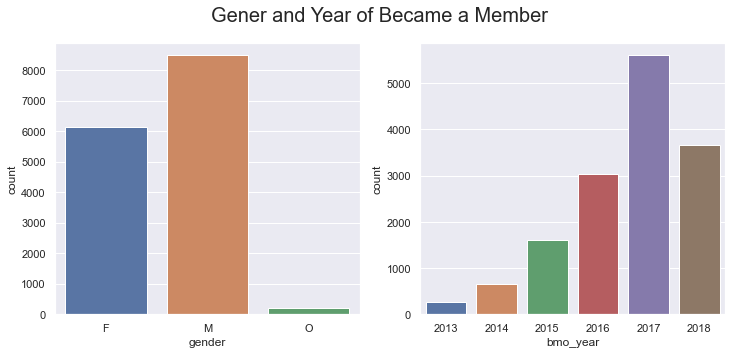

In [9]:
fig_dir = r'..\result\figure\\'
fig_title = 'Gener and Year of Became a Member'

fig, axs = plt.subplots(1,2, figsize=(12,5))
fig.suptitle(fig_title, fontsize=20)

sns.countplot(ax=axs[0], data=df_profile, x='gender')
sns.countplot(ax=axs[1], data=df_profile, x='bmo_year', order=['2013','2014','2015','2016','2017','2018'])

plt.savefig(fig_dir+fig_title+'.png')
plt.show()

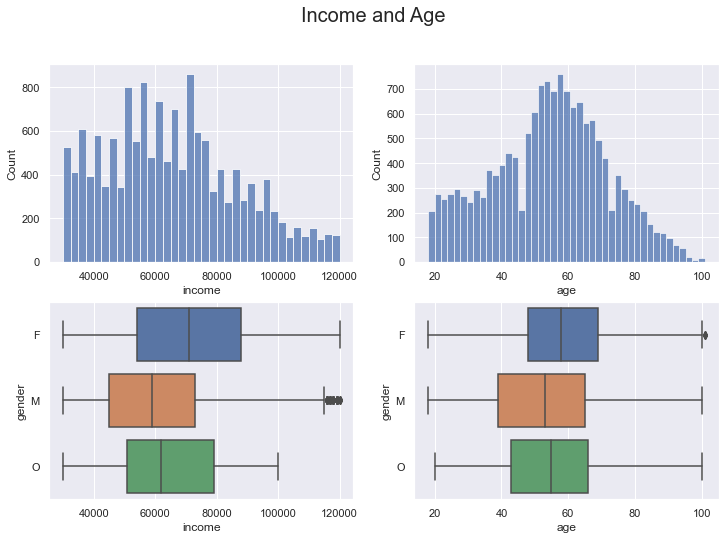

In [10]:
fig_dir = r'..\result\figure\\'
fig_title = 'Income and Age'

fig, axs = plt.subplots(2,2, figsize=(12,8), sharex=False)
fig.suptitle(fig_title, fontsize=20)

sns.boxplot(ax=axs[1,0], data=df_profile, x='income', y='gender')
sns.boxplot(ax=axs[1,1], data=df_profile, x='age', y='gender')
sns.histplot(ax=axs[0,0], data=df_profile, x='income')
sns.histplot(ax=axs[0,1], data=df_profile, x='age')

plt.savefig(fig_dir+fig_title+'.png')
plt.show()

## Inspect Transcript Data

In [11]:
df_transcript

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0
...,...,...,...,...
306529,b3a1272bc9904337b331bf348c3e8c17,transaction,{'amount': 1.5899999999999999},714
306530,68213b08d99a4ae1b0dcb72aebd9aa35,transaction,{'amount': 9.53},714
306531,a00058cf10334a308c68e7631c529907,transaction,{'amount': 3.61},714
306532,76ddbd6576844afe811f1a3c0fbb5bec,transaction,{'amount': 3.5300000000000002},714


In [12]:
df_transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   person  306534 non-null  object
 1   event   306534 non-null  object
 2   value   306534 non-null  object
 3   time    306534 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


In [13]:
df_transcript['person'].nunique()

17000

From sample data above, we know that each person will have more than one rows which contain offer process (received, viewed, and completed) and transaction amount.<br>
We need to extract information of offer id and the amount of transaction from the value column.

### Offer Data

In [14]:
df_offer = df_transcript[df_transcript['event']!='transaction']

pattern = re.compile("{'.+': '([a-z0-9]+)'.*}")
df_offer.loc[:,'offer id'] = df_offer.loc[:,'value'].apply(lambda row: pattern.findall(str(row))[0]) 

pattern2= re.compile("{.+'reward': (\d{1})}")
df_offer.loc[:,'reward'] = df_offer.loc[:,'value'].apply(lambda row: pattern2.findall(str(row)))

df_offer.loc[:,'reward'] = df_offer.loc[:,'reward'].apply(lambda row: row[0] if len(row)>0 else '') 
df_offer = df_offer.drop(columns='value')
df_offer

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


,person,event,time,offer id,reward
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,
2,e2127556f4f64592b11af22de27a7932,offer received,0,2906b810c7d4411798c6938adc9daaa5,
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,fafdcd668e3743c1bb461111dcafc2a4,
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,4d5c57ea9a6940dd891ad53e9dbe8da0,
...,...,...,...,...,...
306497,a6f84f4e976f44508c358cc9aba6d2b3,offer completed,714,2298d6c36e964ae4a3e7e9706d1fb8c2,3
306506,b895c57e8cd047a8872ce02aa54759d6,offer completed,714,fafdcd668e3743c1bb461111dcafc2a4,2
306507,8dda575c2a1d44b9ac8e8b07b93d1f8e,offer viewed,714,0b1e1539f2cc45b7b9fa7c272da2e1d7,
306509,8431c16f8e1d440880db371a68f82dd0,offer completed,714,fafdcd668e3743c1bb461111dcafc2a4,2


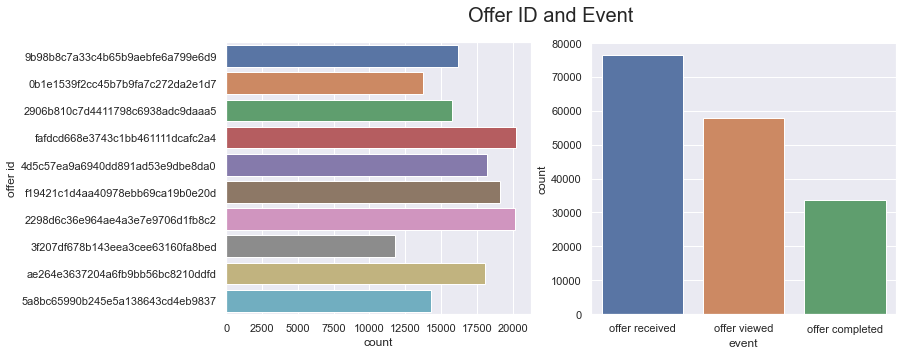

In [15]:
fig_dir = r'..\result\figure\\'
fig_title = 'Offer ID and Event'

fig, axs = plt.subplots(1,2, figsize=(12,5))
fig.suptitle(fig_title, fontsize=20)

sns.countplot(ax=axs[0], data=df_offer, y='offer id')
sns.countplot(ax=axs[1], data=df_offer, x='event')

plt.savefig(fig_dir+fig_title+'png')
plt.show()

### Transaction Data

In [16]:
df_transaction = df_transcript[df_transcript['event']=='transaction']

pattern = re.compile("{'amount': ([0-9.]+)}")
df_transaction.loc[:,'amount'] = df_transaction.loc[:,'value'].apply(lambda row: pattern.findall(str(row))[0])
df_transaction.loc[:,'amount']=df_transaction.loc[:,'amount'].astype('float')

df_transaction = df_transaction.drop(columns = 'value')
df_transaction

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


,person,event,time,amount
12654,02c083884c7d45b39cc68e1314fec56c,transaction,0,0.83
12657,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,transaction,0,34.56
12659,54890f68699049c2a04d415abc25e717,transaction,0,13.23
12670,b2f1cd155b864803ad8334cdf13c4bd2,transaction,0,19.51
12671,fe97aa22dd3e48c8b143116a8403dd52,transaction,0,18.97
...,...,...,...,...
306529,b3a1272bc9904337b331bf348c3e8c17,transaction,714,1.59
306530,68213b08d99a4ae1b0dcb72aebd9aa35,transaction,714,9.53
306531,a00058cf10334a308c68e7631c529907,transaction,714,3.61
306532,76ddbd6576844afe811f1a3c0fbb5bec,transaction,714,3.53


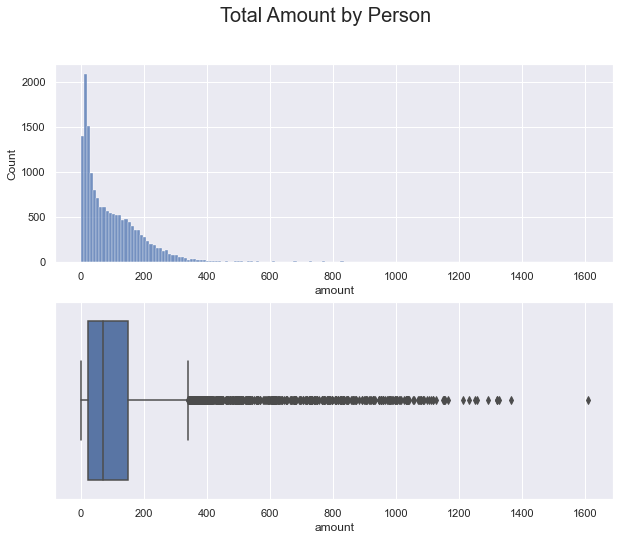

In [17]:
fig_dir = r'..\result\figure\\'
fig_title = 'Total Amount by Person'


df_persontrans = pd.DataFrame(df_transaction.groupby('person').sum()['amount'])
df_persontrans = df_persontrans.reset_index(inplace=False)

fig, axs = plt.subplots(2,1, figsize=(10,8))
fig.suptitle(fig_title, fontsize=20)

sns.histplot(x=df_persontrans['amount'],ax=axs[0])
sns.boxplot(x=df_persontrans['amount'],ax=axs[1])
plt.show()

In [18]:
df_transcript = pd.concat([df_offer,df_transaction])
df_transcript

,person,event,time,offer id,reward,amount
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,,NaN
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,,NaN
2,e2127556f4f64592b11af22de27a7932,offer received,0,2906b810c7d4411798c6938adc9daaa5,,NaN
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,fafdcd668e3743c1bb461111dcafc2a4,,NaN
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,4d5c57ea9a6940dd891ad53e9dbe8da0,,NaN
...,...,...,...,...,...,...
306529,b3a1272bc9904337b331bf348c3e8c17,transaction,714,NaN,NaN,1.59
306530,68213b08d99a4ae1b0dcb72aebd9aa35,transaction,714,NaN,NaN,9.53
306531,a00058cf10334a308c68e7631c529907,transaction,714,NaN,NaN,3.61
306532,76ddbd6576844afe811f1a3c0fbb5bec,transaction,714,NaN,NaN,3.53


## Inspect Portfolio Data

In [19]:
df_portfolio

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


In [20]:
df = df_profile.merge(df_transcript, left_on='id', right_on='person', how='left')
df = df.merge(df_portfolio, left_on='offer id', right_on='id', how='left')
#df = df.replace(np.nan, '', regex=True)
df = df.drop(columns=['id_x','id_y'])
df.sample(10)

,gender,age,became_member_on,income,bmo_year,person,event,time,offer id,reward_x,amount,reward_y,channels,difficulty,duration,offer_type
84528,F,54,2018-05-01,81000.0,2018,3f5dc181f374492f8d1a84fb7d68ec3d,transaction,426,NaN,NaN,24.29,NaN,NaN,NaN,NaN,NaN
110093,M,29,2017-11-15,49000.0,2017,4e46337117a043c181b644414d2aa5f7,transaction,690,NaN,NaN,13.11,NaN,NaN,NaN,NaN,NaN
23545,M,70,2017-08-03,105000.0,2017,8fc40f08bcc7442796802b19ffcc9e04,offer received,504,2906b810c7d4411798c6938adc9daaa5,,NaN,2.0,"[web, email, mobile]",10.0,7.0,discount
244967,F,63,2018-01-03,103000.0,2018,ba1d6debf43549ec85647318dda2656d,transaction,672,NaN,NaN,30.22,NaN,NaN,NaN,NaN,NaN
229464,M,72,2014-02-07,39000.0,2014,c7a6bf2558554bf5954ed506eb3968f1,offer viewed,540,f19421c1d4aa40978ebb69ca19b0e20d,,NaN,5.0,"[web, email, mobile, social]",5.0,5.0,bogo
36793,M,87,2015-11-23,48000.0,2015,f89a821a9dd240fbbf05c17f24452ae8,transaction,588,NaN,NaN,2.57,NaN,NaN,NaN,NaN,NaN
68696,M,28,2018-05-11,37000.0,2018,d20b60b322fc464f8bf26593330880c5,offer viewed,600,f19421c1d4aa40978ebb69ca19b0e20d,,NaN,5.0,"[web, email, mobile, social]",5.0,5.0,bogo
167737,F,65,2018-02-21,56000.0,2018,f3f6c8c262ff4a7eba241cc1d8c1836d,transaction,528,NaN,NaN,3.06,NaN,NaN,NaN,NaN,NaN
106192,F,58,2017-10-14,73000.0,2017,7aabd3e693e94246be8cfe31adec3b86,transaction,444,NaN,NaN,10.21,NaN,NaN,NaN,NaN,NaN
4167,M,43,2017-04-13,71000.0,2017,b21beefac7b6488f8384774c4d90faca,transaction,78,NaN,NaN,23.13,NaN,NaN,NaN,NaN,NaN


In [21]:
df.describe()

,age,income,time,amount,reward_y,difficulty,duration
count,272762.000000,272762.000000,272762.000000,123957.000000,148805.000000,148805.000000,148805.000000
mean,53.840696,64337.000755,366.707694,13.996325,4.442445,7.890561,6.625207
std,17.551337,21243.762941,200.359087,31.749420,3.372362,5.041335,2.133035
min,18.000000,30000.000000,0.000000,0.050000,0.000000,0.000000,3.000000
25%,41.000000,48000.000000,186.000000,3.660000,2.000000,5.000000,5.000000
50%,55.000000,62000.000000,408.000000,10.800000,5.000000,10.000000,7.000000
75%,66.000000,78000.000000,528.000000,19.130000,5.000000,10.000000,7.000000
max,101.000000,120000.000000,714.000000,1062.280000,10.000000,20.000000,10.000000


In [22]:
df_offer.sample(5)

,person,event,time,offer id,reward
227650,b991c17777804054bf73313153cb9476,offer completed,522,ae264e3637204a6fb9bb56bc8210ddfd,
274051,c67954e658564adc918c8d086f09082b,offer completed,600,2906b810c7d4411798c6938adc9daaa5,2
150674,21c73d53e2a74bb1b4dc172bff2b1aad,offer received,408,2298d6c36e964ae4a3e7e9706d1fb8c2,
233951,3b88b75cc2444adeaed87401ce7471d1,offer viewed,540,5a8bc65990b245e5a138643cd4eb9837,
257253,2dc7fa1c3547421f8e4792839348bb81,offer received,576,4d5c57ea9a6940dd891ad53e9dbe8da0,


In [23]:
df_portfolio

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


## Export Cleansed Data

In [24]:
cleansed_dir = r'..\data\cleansed\\'
file_name = 'data.csv'

df.to_csv(cleansed_dir+file_name, index=False, header=True)